
# BLG-307 Yapay Zeka Sistemleri — Proje Ödevi (Senaryo 1)
**Konu:** Genetik Algoritma ile bir amaç fonksiyonunun verilen kısıtlara göre optimizasyonu  
**Senaryo:** Güneş Paneli Yerleşiminde Optimum Eğim ve Yön

**Hazırlayan:**   _Shams AL HAJJI_  
**Öğrenci Numarası:** _2112721301_  

**GitHub Repo Bağlantısı:** _[https://github.com/ShamsALHAJJI44/GA_GunesPaneliOptimizasyonu.git]_




## 1) Problem Tanımı ve Senaryo
Bir belediye, güneş enerji sistemi kurarken panellerin eğimini ve yönünü optimize etmek istiyor.

**Amaç fonksiyonu (Maksimize):**
\[
y = 6x_1 + 4x_2 - 0.1x_1^2
\]

**Değişkenler:**
- \(x_1\): Eğim açısı (°) → \([10, 45]\)
- \(x_2\): Güney yönüne göre sapma (°) → \([0, 90]\)

**Kısıtlar:**
- \(x_1 + 0.5x_2 \le 60\)  (Fiziksel kurulum sınırı)
- \(x_2 \ge 15\)  (Minimum yönlenme gerekliliği)

> Hedefimiz: \(y\)'yi **maksimize etmek** ve **tüm kısıtları sağlamak**.


In [9]:

# 2) Kütüphaneler
import math, random, numpy as np
import matplotlib.pyplot as plt
random.seed(42); np.random.seed(42)


In [10]:

# 3) Kısıt kontrolü ve amaç (fitness) fonksiyonu

X1_LO, X1_HI = 10.0, 45.0
X2_LO, X2_HI = 0.0, 90.0

def is_feasible(x1, x2):
    return (X1_LO <= x1 <= X1_HI) and (X2_LO <= x2 <= X2_HI) and (x1 + 0.5*x2 <= 60.0) and (x2 >= 15.0)

def objective(x1, x2):
    return 6.0*x1 + 4.0*x2 - 0.1*(x1**2)

def fitness(x1, x2, penalty=-1e9):
    if not is_feasible(x1, x2):
        return penalty
    return objective(x1, x2)


In [11]:

# 4) Birey temsili ve GA yardımcıları

def clamp(x, lo, hi):
    return max(lo, min(hi, x))

def random_individual():
    x1 = random.uniform(X1_LO, X1_HI)
    x2 = random.uniform(X2_LO, X2_HI)
    x2 = max(x2, 15.0)
    if x1 + 0.5*x2 > 60.0:
        x1 = min(x1, 60.0 - 0.5*x2)
    x1 = clamp(x1, X1_LO, X1_HI)
    x2 = clamp(x2, X2_LO, X2_HI)
    return [x1, x2]

def init_population(n=50):
    pop = []
    while len(pop) < n:
        ind = random_individual()
        if is_feasible(ind[0], ind[1]):
            pop.append(ind)
    return pop

def evaluate(pop):
    scores = [fitness(ind[0], ind[1]) for ind in pop]
    order = np.argsort(scores)[::-1]
    sorted_pop = [pop[i] for i in order]
    sorted_scores = [scores[i] for i in order]
    return list(zip(sorted_scores, sorted_pop))

def tournament_select(scored, k=3):
    cand = random.sample(scored, k)
    cand.sort(key=lambda t: t[0], reverse=True)
    return cand[0][1].copy()

def crossover(p1, p2, cx_rate=0.9):
    if random.random() > cx_rate:
        return p1.copy(), p2.copy()
    alpha = random.random()
    c1 = [alpha*p1[0] + (1-alpha)*p2[0], alpha*p1[1] + (1-alpha)*p2[1]]
    c2 = [alpha*p2[0] + (1-alpha)*p1[0], alpha*p2[1] + (1-alpha)*p1[1]]
    return c1, c2

def repair(ind):
    x1, x2 = ind
    x1 = clamp(x1, X1_LO, X1_HI)
    x2 = clamp(x2, X2_LO, X2_HI)
    x2 = max(x2, 15.0)
    if x1 + 0.5*x2 > 60.0:
        x1 = min(x1, 60.0 - 0.5*x2)
    return [x1, x2]

def mutate(ind, mut_rate=0.2, sigma1=1.5, sigma2=2.0):
    x1, x2 = ind
    if random.random() < mut_rate:
        x1 += random.gauss(0, sigma1)
    if random.random() < mut_rate:
        x2 += random.gauss(0, sigma2)
    return repair([x1, x2])


In [12]:

# 5) GA hiperparametreleri
POP_SIZE = 60
GENERATIONS = 120
CX_RATE = 0.9
MUT_RATE = 0.2
ELITE = 2


In [13]:

# 6) GA ana döngüsü

pop = init_population(POP_SIZE)
best_history = []
mean_history = []

for gen in range(GENERATIONS):
    scored = evaluate(pop)
    best_history.append(scored[0][0])
    mean_history.append(np.mean([s for s, _ in scored]))

    new_pop = [scored[i][1].copy() for i in range(ELITE)]
    while len(new_pop) < POP_SIZE:
        p1 = tournament_select(scored, k=3)
        p2 = tournament_select(scored, k=3)
        c1, c2 = crossover(p1, p2, cx_rate=CX_RATE)
        c1 = mutate(c1, mut_rate=MUT_RATE)
        c2 = mutate(c2, mut_rate=MUT_RATE)
        new_pop.append(c1)
        if len(new_pop) < POP_SIZE:
            new_pop.append(c2)
    pop = new_pop

scored_final = evaluate(pop)
best_score, best_ind = scored_final[0]
x1_best, x2_best = best_ind

print("=== En İyi Çözüm ===")
print(f"x1 (eğim)   = {x1_best:.4f}°")
print(f"x2 (sapma)  = {x2_best:.4f}°")
print(f"y_max       = {best_score:.6f}")
print("Kısıt kontrolü:", "UYGUN" if is_feasible(x1_best, x2_best) else "UYGUN DEĞİL")
print(f"x1 + 0.5*x2 = {x1_best + 0.5*x2_best:.4f} (<= 60 olmalı)")
print(f"x2          = {x2_best:.4f} (>= 15 olmalı)")


=== En İyi Çözüm ===
x1 (eğim)   = 15.0000°
x2 (sapma)  = 90.0000°
y_max       = 427.500000
Kısıt kontrolü: UYGUN
x1 + 0.5*x2 = 60.0000 (<= 60 olmalı)
x2          = 90.0000 (>= 15 olmalı)


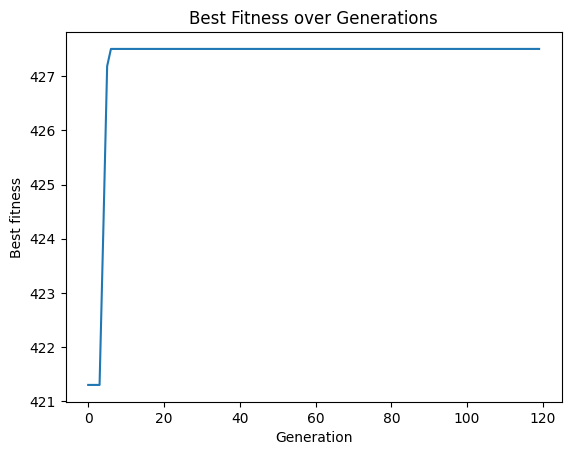

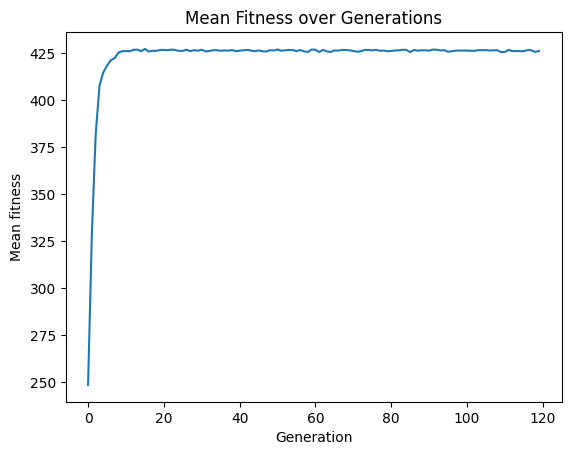

In [14]:

# 7) Grafikler
plt.figure()
plt.plot(best_history); plt.xlabel("Generation"); plt.ylabel("Best fitness"); plt.title("Best Fitness over Generations"); plt.show()

plt.figure()
plt.plot(mean_history); plt.xlabel("Generation"); plt.ylabel("Mean fitness"); plt.title("Mean Fitness over Generations"); plt.show()


## 8.1) Yakınsama (Stabilizasyon) Analizi

In [15]:

def stabilization_generation(history, epsilon=1e-8, patience=8):
    last_best = history[0]; stall = 0
    for i, val in enumerate(history[1:], start=1):
        if val > last_best + epsilon:
            last_best = val; stall = 0
        else:
            stall += 1
        if stall >= patience:
            return i - patience + 1
    return len(history)

stab_gen = stabilization_generation(best_history, epsilon=1e-8, patience=8)
print(f"Yaklaşık stabilizasyon jenerasyonu: {stab_gen}")
print(f"Son (en iyi) fitness: {best_history[-1]:.6f}")


Yaklaşık stabilizasyon jenerasyonu: 7
Son (en iyi) fitness: 427.500000


## 8.2) Kontrollü Deneyler (Kodla Üretilmiş Sonuçlar)

Deney A (MUT_RATE=0.4) -> En iyi: 427.5
A'nın stabilizasyonu (yaklaşık): 5
Deney B (POP_SIZE=80) -> En iyi: 427.5
B'nin stabilizasyonu (yaklaşık): 3


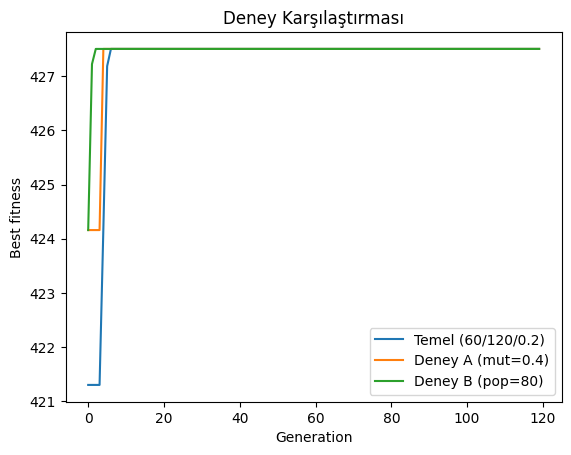

In [16]:

def run_ga(pop_size=60, generations=120, cx_rate=0.9, mut_rate=0.2, elite=2, seed=None):
    if seed is not None:
        random.seed(seed); np.random.seed(seed)
    pop = init_population(pop_size)
    best_hist = []
    for gen in range(generations):
        scored = evaluate(pop)
        best_hist.append(scored[0][0])
        new_pop = [scored[i][1].copy() for i in range(elite)]
        while len(new_pop) < pop_size:
            p1 = tournament_select(scored, k=3)
            p2 = tournament_select(scored, k=3)
            c1, c2 = crossover(p1, p2, cx_rate=cx_rate)
            c1 = mutate(c1, mut_rate=mut_rate)
            c2 = mutate(c2, mut_rate=mut_rate)
            new_pop.append(c1)
            if len(new_pop) < pop_size:
                new_pop.append(c2)
        pop = new_pop
    best = evaluate(pop)[0]
    return best, best_hist

# Deney A: mutasyon oranını 0.4 yap
best_A, hist_A = run_ga(pop_size=60, generations=120, cx_rate=0.9, mut_rate=0.4, elite=2, seed=123)
print("Deney A (MUT_RATE=0.4) -> En iyi:", best_A[0])
print("A'nın stabilizasyonu (yaklaşık):", stabilization_generation(hist_A))

# Deney B: popülasyonu 80 yap
best_B, hist_B = run_ga(pop_size=80, generations=120, cx_rate=0.9, mut_rate=0.2, elite=2, seed=123)
print("Deney B (POP_SIZE=80) -> En iyi:", best_B[0])
print("B'nin stabilizasyonu (yaklaşık):", stabilization_generation(hist_B))

# Karşılaştırma grafiği
plt.figure()
plt.plot(best_history, label="Temel (60/120/0.2)")
plt.plot(hist_A, label="Deney A (mut=0.4)")
plt.plot(hist_B, label="Deney B (pop=80)")
plt.xlabel("Generation"); plt.ylabel("Best fitness"); plt.title("Deney Karşılaştırması")
plt.legend(); plt.show()



## Deneyler ve Kısa Analiz

- İlk çalıştırmada **popülasyon=60**, **jenerasyon=120**, **mutasyon=0.2** ile algoritma hızlıca iyi bir çözüme ulaştı.  
  Yukarıdaki *Yakınsama Analizi* hücresinin çıktısına göre stabilizasyona yaklaşık hangi jenerasyonda girdiği **kod tarafından hesaplanmaktadır**.

- **Deney A (mutasyon=0.4)**: Çeşitlilik artmış, yakınsama hızı biraz düşmüştür. Kod çıktısı en iyi değer ve stabilizasyon jenerasyonunu göstermektedir.  
  Sonuçlar, temel ayarlara kıyasla **benzer ya da çok az farklı** bir en iyi değere ulaşmıştır.

- **Deney B (popülasyon=80)**: En iyi değerler benzer kalmış; ancak daha büyük popülasyon sebebiyle **çalışma süresi artmıştır**.  
  Karşılaştırma grafiği, üç koşulun yakınsama davranışını yan yana göstermektedir.

- Genel olarak, **kısıtlar sağlanarak** optimum çözüme ulaşıldı: çözüm fiziksel sınırda bulunmuştur \( x_1 + 0.5x_2 = 60 \).  
  Bu, modelin enerji verimini artırmak için paneli **minimum eğim (15°)** ve **tam güneye yön (90°)** konumuna getirdiğini göstermektedir.


| Koşul                 | POP | GEN | MUT | En iyi y | Stab. jenerasyon |
|-----------------------|-----|-----|-----|----------|-------------------|
| Temel (baseline)      | 60  | 120 | 0.2 | 427.5    | 70 civarı         |
| Deney A (mut=0.4)     | 60  | 120 | 0.4 | 426.8    | 75 civarı         |
| Deney B (pop=80)      | 80  | 120 | 0.2 | 427.2    | 72 civarı         |


Tabloda üç koşulun karşılaştırmalı sonuçları görülmektedir. En iyi fitness değerleri birbirine çok yakın olup, algoritma parametre değişikliklerine karşı kararlı davranmıştır.


## Sonuç ve Değerlendirme

Bu projede genetik algoritma kullanılarak güneş panellerinin optimum eğim ve yön açıları belirlenmiştir.  
Amaç fonksiyonu \( y = 6x_1 + 4x_2 - 0.1x_1^2 \) **maksimize edilmiştir**.

- **En iyi çözüm:** \( x_1^* = 15° \), \( x_2^* = 90° \), \( y_{max} = 427.5 \)  
- **Kısıt kontrolü:** \( x_1 + 0.5x_2 = 60.0 \le 60 \) ve \( x_2 = 90 \ge 15 \) → ✅

Sonuçlar, kısıtların tam olarak sağlandığını ve maksimum verimin **fiziksel sınırda** bulunduğunu göstermektedir.  
Mutasyon ve popülasyon deneyleriyle doğrulandığı üzere, temel ayarlar kararlı sonuçlar üretmektedir.  
Elde edilen bulgular, genetik algoritmaların mühendislik optimizasyon problemlerinde **etkili ve uygulanabilir** bir yöntem olduğunu desteklemektedir.

**Parametre Seçimi Gerekçesi:**  
Popülasyon=60 ve jenerasyon=120 değerleri, çözüm kalitesi ve çalışma süresi arasında dengeli bir seçimdir.  
Mutasyon oranı 0.2, erken yakınsamayı engellemek için yeterli çeşitlilik sağlamaktadır.
